In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from Environment import Dealer, BlackjackEnv
from agent import QLearningAgent, ReinforceAgent
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

global_number_episodes = 50000


ModuleNotFoundError: No module named 'matplotlib'

# Watkins Q-Learning Agent 

For the case where the number of decks used to deal is infinite, We can make use of Watkins Q-Learning. This is a temporal difference method. 

The general method is as follows: 

1. An initial Q-table is created, giving hit and stick for all the hand values as equal (all have an initial Q-value of 0)
2. a hand is played, the Q-values are updated according the the update rule after each card is drawn. (Reward is only given after the hand is over is the player doesnt bust)
3. steps 1 and 2 are repeated and the Q_table is updated until the Q_values converge.
4. The learned Q-table is then the policy that the agent has learned to maximise its reward per-hand. 

Q update rule:
 $$Q(S,A) \to (1-\alpha)Q(S,A) + \alpha[R + \gamma \max_{a}Q(S',a)]$$

 In this case we can set the discount factor $\gamma$ = 1, as we are only interested in the reward after the hand has been played. $\alpha$ is the learning rate. 

The Q-values in the table represent the expected reward for a hand given a specific action and state. For example if the Q-value for hitting when the hand value is 13 is 153.2, the exepected or average reward for a hand given hitting on 13 is 153.2

Testing the Q learning agent for an infinite deck of cards 

In [445]:
#initialize agent for Q-learning
env = BlackjackEnv(D=np.inf)
q_agent = QLearningAgent(env, alpha=0.1, gamma=1)

In [446]:
average_reward_01 = q_agent.learn(num_episodes=global_number_episodes,epsilon=0.1,decay_epsilon=False)

env = BlackjackEnv(D=np.inf)
q_agent_01 = QLearningAgent(env, alpha=0.1, gamma=1)

average_reward_01 = q_agent_01.learn(num_episodes=global_number_episodes,epsilon=0.1,decay_epsilon=False)

env = BlackjackEnv(D=np.inf)
q_agent = QLearningAgent(env, alpha=0.1, gamma=1)

average_reward_001 = q_agent.learn(num_episodes=global_number_episodes,epsilon=0.01,decay_epsilon=False)

env = BlackjackEnv(D=np.inf)
q_agent = QLearningAgent(env, alpha=0.1, gamma=1)

average_reward_03 = q_agent.learn(num_episodes=global_number_episodes,epsilon=0.3,decay_epsilon=False)

Episode 100 completed (0.20%). Moving Average Reward: 219.34
Episode 200 completed (0.40%). Moving Average Reward: 225.09
Episode 300 completed (0.60%). Moving Average Reward: 250.56
Episode 400 completed (0.80%). Moving Average Reward: 214.47
Episode 500 completed (1.00%). Moving Average Reward: 247.43
Episode 600 completed (1.20%). Moving Average Reward: 261.06
Episode 700 completed (1.40%). Moving Average Reward: 251.86
Episode 800 completed (1.60%). Moving Average Reward: 256.89
Episode 900 completed (1.80%). Moving Average Reward: 251.97
Episode 1000 completed (2.00%). Moving Average Reward: 242.06
Episode 1100 completed (2.20%). Moving Average Reward: 267.14
Episode 1200 completed (2.40%). Moving Average Reward: 254.88
Episode 1300 completed (2.60%). Moving Average Reward: 279.45
Episode 1400 completed (2.80%). Moving Average Reward: 267.41
Episode 1500 completed (3.00%). Moving Average Reward: 254.31
Episode 1600 completed (3.20%). Moving Average Reward: 239.61
Episode 1700 comp

Visualise learnd policy (q-values)

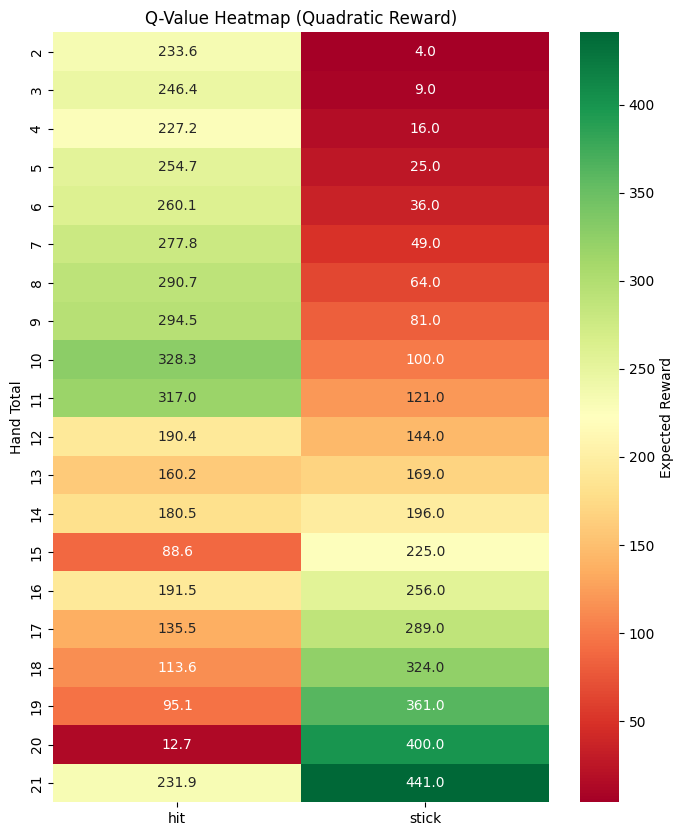

In [447]:
df = pd.Series(q_agent_01.Q_values).unstack()

df.index.name = 'Hand Total'
df = df.sort_index()

plt.figure(figsize=(8, 10))
sns.heatmap(df, annot=True, fmt=".1f", cmap="RdYlGn", cbar_kws={'label': 'Expected Reward'})
plt.title("Q-Value Heatmap (Quadratic Reward)")
plt.show()

Visualise the learning process:

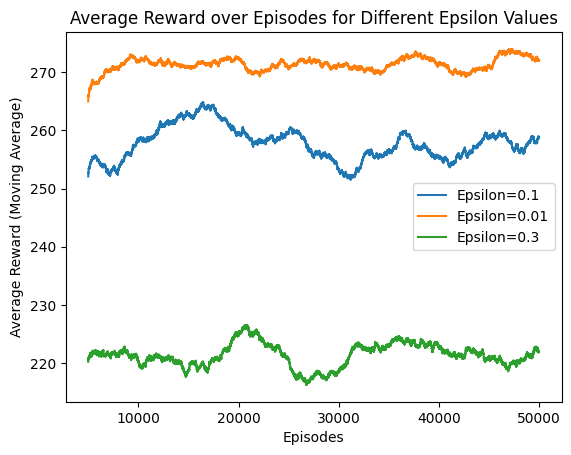

In [448]:
window_size = global_number_episodes // 10
weights = np.ones(window_size) / window_size

moving_avg_01 = np.convolve(average_reward_01, weights, mode='valid')
moving_avg_001 = np.convolve(average_reward_001, weights, mode='valid')
moving_avg_03 = np.convolve(average_reward_03, weights, mode='valid')

episodes = np.arange(window_size, len(average_reward_01) + 1)



plt.plot(episodes, moving_avg_01, label='Epsilon=0.1')
plt.plot(episodes, moving_avg_001, label='Epsilon=0.01')
plt.plot(episodes, moving_avg_03, label='Epsilon=0.3')
plt.xlabel('Episodes')
plt.ylabel('Average Reward (Moving Average)')
plt.title('Average Reward over Episodes for Different Epsilon Values')
plt.legend()

With a static epsilon, we see the reward increase jumping around and not reaching a very good level. To improve this we can introduce an epsilon decay throughout the learning process. This way the model can explore all the states often early in the training and as it learns what is effective it will explore less. 

We can use an exponential decay to decay $\epsilon$ from $\epsilon_{upper} = 1$ to $\epsilon_{lower} = 0.01$ during the training. 

$$\epsilon = \epsilon_{lower} + (\epsilon_{upper}-\epsilon_{lower})\exp(-5\frac{\text{episode iteratation}}{\text{total episodes}})$$

In [449]:
#initialize agent for Q-learning
env = BlackjackEnv(D=np.inf)
q_agent_edec = QLearningAgent(env, alpha=0.1, gamma=1)

In [450]:
q_agent_edec.env.reset_deck()

average_reward_edec = q_agent_edec.learn(num_episodes=global_number_episodes,decay_epsilon=True)

Episode 100 completed (0.20%). Moving Average Reward: 139.45
Episode 200 completed (0.40%). Moving Average Reward: 103.85
Episode 300 completed (0.60%). Moving Average Reward: 128.43
Episode 400 completed (0.80%). Moving Average Reward: 106.82
Episode 500 completed (1.00%). Moving Average Reward: 114.42
Episode 600 completed (1.20%). Moving Average Reward: 138.26
Episode 700 completed (1.40%). Moving Average Reward: 101.29
Episode 800 completed (1.60%). Moving Average Reward: 139.47
Episode 900 completed (1.80%). Moving Average Reward: 119.99
Episode 1000 completed (2.00%). Moving Average Reward: 154.94
Episode 1100 completed (2.20%). Moving Average Reward: 126.2
Episode 1200 completed (2.40%). Moving Average Reward: 146.39
Episode 1300 completed (2.60%). Moving Average Reward: 133.84
Episode 1400 completed (2.80%). Moving Average Reward: 146.96
Episode 1500 completed (3.00%). Moving Average Reward: 147.83
Episode 1600 completed (3.20%). Moving Average Reward: 146.06
Episode 1700 compl

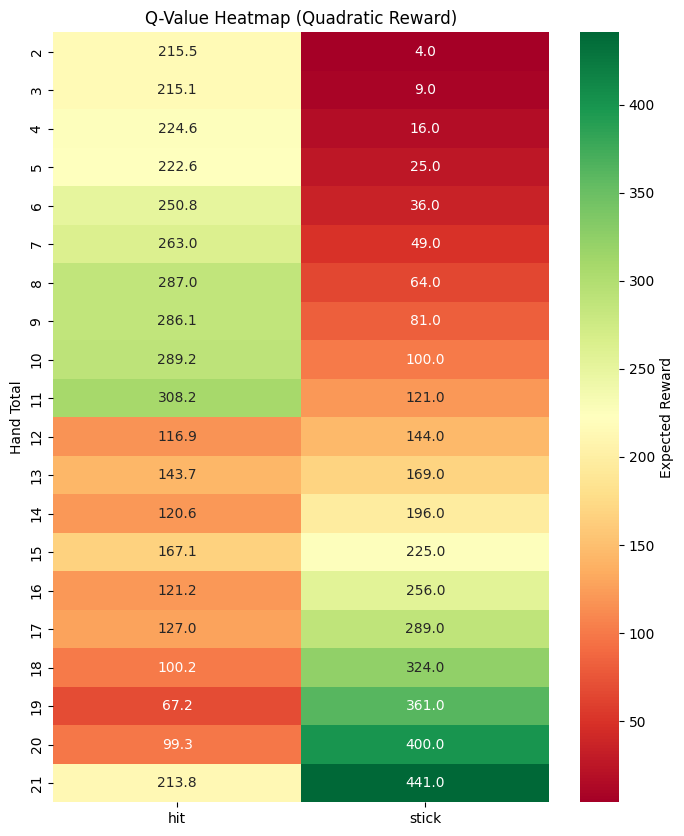

In [451]:
df = pd.Series(q_agent_edec.Q_values).unstack()

df.index.name = 'Hand Total'
df = df.sort_index()

plt.figure(figsize=(8, 10))
sns.heatmap(df, annot=True, fmt=".1f", cmap="RdYlGn", cbar_kws={'label': 'Expected Reward'})
plt.title("Q-Value Heatmap (Quadratic Reward)")
plt.show()

Text(0.5, 1.0, 'Q-Learning Agent Training Performance')

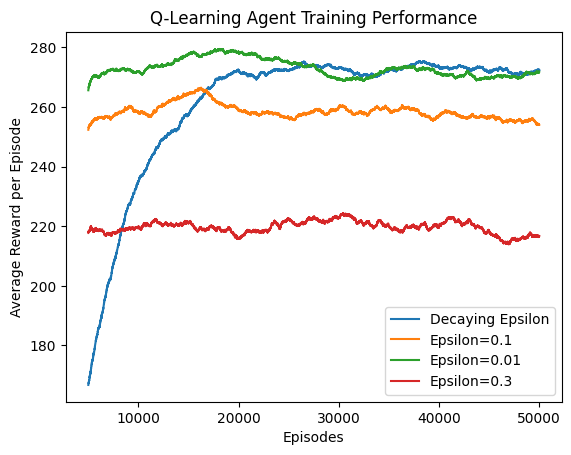

In [443]:
window_size = global_number_episodes // 10
weights = np.ones(window_size) / window_size
moving_avg_edec = np.convolve(average_reward_edec, weights, mode='valid')
episodes = np.arange(window_size, len(average_reward_edec) + 1)
plt.plot(episodes, moving_avg_edec, label='Decaying Epsilon')
plt.plot(episodes, moving_avg_01, label='Epsilon=0.1')
plt.plot(episodes, moving_avg_001, label='Epsilon=0.01')
plt.plot(episodes, moving_avg_03, label='Epsilon=0.3')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average Reward per Episode')
plt.title('Q-Learning Agent Training Performance')

## Results 

we can see the decaying epsilon agent acheives the highest reward per hand. It learned q-values suggest it has learnt to hit on hand values of 11 and lower. This may be because hitting on 11 is imposible to bust, so the agent ensures it always gains some reward each hand.  

# REINFORCE LEARNING AGENT 

For the case where the number of decks is D < $\infty$ the problem becomes more complex; the state space is no longer just the value of the current hand, it now includes some history of the cards that have appeared. The method Q-learning will not be feasable since the state space will become too large when the number of decks is large. Instead we can use a policy gradient method since these make use of function approximation to map the state inputs to action probabilities.  

This function is effectively a linear model with a sigmoid function to give a probability of hitting or sticking, the training process will be using gradient acent (acent because we want to $\textbf{maximise}$ the reward) to update the parameters based on the reward throughout playing hands. 

We will need create a feature vector to represent the state space, for this case we will need 13 for how many of each each card type the agent has seen and 1 for the current value of the hand, there is 1 extra bias feature. So in total we will have a feature matrix of 15x1. 

We will create a parameterised policy, which is the linear model mentioned ealier. The models parameters will be updated according to:

$$\theta \to \theta + \alpha \gamma^{t}G\Delta_{\theta}log(A_t | S_t)$$

In [391]:
env = BlackjackEnv(D=1)
r_agent = ReinforceAgent(env)
episode_reward = r_agent.train_agent_vectorised(num_episodes=global_number_episodes, learning_rate=0.01, gamma=0.99, ADAM=False)

Text(0.5, 1.0, 'REINFORCE Agent Training Performance')

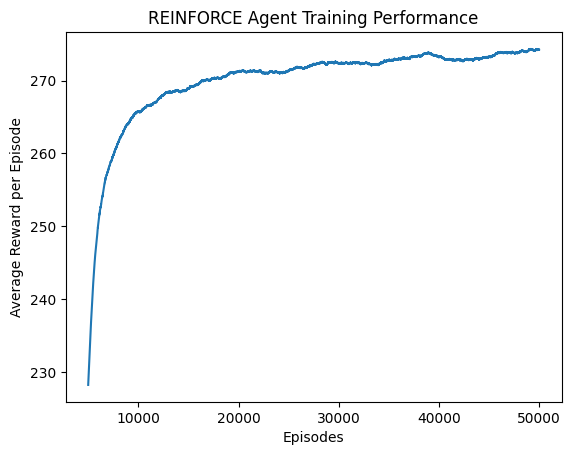

In [392]:
window_size = global_number_episodes // 10
weights = np.ones(window_size) / window_size
moving_avg = np.convolve(episode_reward, weights, mode='valid')
episodes = np.arange(window_size, len(episode_reward) + 1)
plt.plot(episodes, moving_avg)
plt.xlabel('Episodes')
plt.ylabel('Average Reward per Episode')
plt.title('REINFORCE Agent Training Performance')

Since this is now quite computationaly expensive, We will implement ADAM to try and decrease convergence time: 

ADAM implments two key ideas that both use moving averages: 

1. Momentum, updates the step direction based on the direction we have been traveling
2. Velocity, updates the step size based on the magniute of acent we have been doing

These will smooth out the learning process and allow the model to converge quicker 

Implemting them in this model involves modifying the update rule: 

currently: 

$$\theta \to \theta + \alpha g_t$$

with $g_t = \gamma^{t}G\Delta_{\theta}log(A_t | S_t)$ 

This $g_t$ is then used to calculate the moving averages stated earlier. These moving averages are then what will be used in the update rule. The moving averages are updated as follows: (initialised at 0)

Momentum: 

$$m_t \to \beta_{1}m_t + (1-\beta_1) g_t$$

Velocity: 

$$v_t \to \beta_2 v_t + (1-\beta_2)g_t^2$$

Since these are initialised to 0 at the start of training, we need to correct for this bias: 

$$\hat{m_t} = \frac{m_t}{1-\beta_1^t}$$

$$\hat{v_t} = \frac{v_t}{1-\beta_2^t}$$

The update rule then becomes: 

$$\theta \to \theta + \alpha \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon }$$





Note: With Adam we can set a higher learning rate for the same number of episodes, this would not work without since training would be too eratic. \
$\epsilon$ is just a small number > 0 to prevent division by 0 errors

The following code will test the agent using learning rates 0.1,0.01,0.001 with and without adam 

In [393]:
# time the difference between vectorised and non-vectorised and ADAM vs no ADAM

import time 
number_of_episodes = global_number_episodes

# ---- learning rate 0.1 ----
learning_rate = 0.1
# no ADAM 
env = BlackjackEnv(D=1)
r_agent = ReinforceAgent(env)
start_time = time.time()
episode_reward_01 = r_agent.train_agent_vectorised(num_episodes=number_of_episodes, learning_rate=learning_rate, gamma=0.99, ADAM=False)
print("training time: %s seconds (lr=0.1)" % (time.time() - start_time))

env = BlackjackEnv(D=1)
r_agent_adam = ReinforceAgent(env)

start_time = time.time()
episode_reward_adam_01 = r_agent_adam.train_agent_vectorised(num_episodes=number_of_episodes, learning_rate=learning_rate,gamma=0.99,ADAM=True)
print("ADAM training time: %s seconds (lr=0.1)" % (time.time() - start_time))

# ---- learning rate 0.01 ----
learning_rate = 0.01
# no ADAM 
env = BlackjackEnv(D=1)
r_agent = ReinforceAgent(env)
start_time = time.time()
episode_reward_001 = r_agent.train_agent_vectorised(num_episodes=number_of_episodes, learning_rate=learning_rate, gamma=0.99, ADAM=False)
print("Standard training time: %s seconds (lr=0.01)" % (time.time() - start_time))

env = BlackjackEnv(D=1)
r_agent_adam = ReinforceAgent(env)

start_time = time.time()
episode_reward_adam_001 = r_agent_adam.train_agent_vectorised(num_episodes=number_of_episodes, learning_rate=learning_rate,gamma=0.99,ADAM=True)
print(" ADAM training time: %s seconds (lr=0.01)" % (time.time() - start_time))

# ---- learning rate 0.001 ----
learning_rate = 0.001
# no ADAM 
env = BlackjackEnv(D=1)
r_agent = ReinforceAgent(env)
start_time = time.time()
episode_reward_0001 = r_agent.train_agent_vectorised(num_episodes=number_of_episodes, learning_rate=learning_rate, gamma=0.99, ADAM=False)
print("Standard training time: %s seconds (lr=0.001)" % (time.time() - start_time))

env = BlackjackEnv(D=1)
r_agent_adam = ReinforceAgent(env)

start_time = time.time()
episode_reward_adam_0001 = r_agent_adam.train_agent_vectorised(num_episodes=number_of_episodes, learning_rate=learning_rate,gamma=0.99,ADAM=True)
print(" ADAM training time: %s seconds (lr=0.001)" % (time.time() - start_time))

training time: 50.741050481796265 seconds (lr=0.1)
ADAM training time: 78.6153199672699 seconds (lr=0.1)
Standard training time: 53.204649448394775 seconds (lr=0.01)
 ADAM training time: 85.68714213371277 seconds (lr=0.01)
Standard training time: 75.85427832603455 seconds (lr=0.001)
 ADAM training time: 88.37463784217834 seconds (lr=0.001)


Text(0.5, 1.0, 'REINFORCE Agent Training Performance')

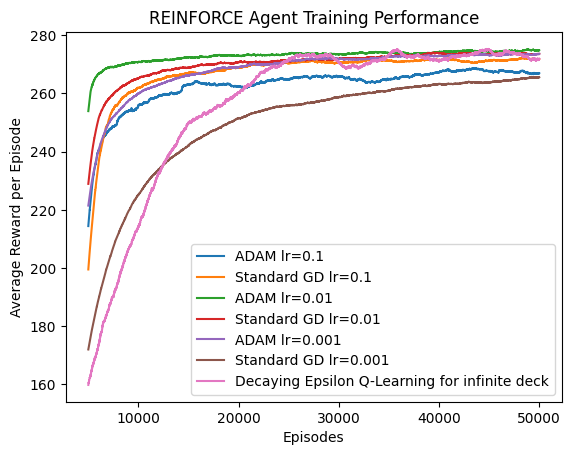

In [394]:
window_size = global_number_episodes // 10
weights = np.ones(window_size) / window_size

moving_avg_adam_01 = np.convolve(episode_reward_adam_01, weights, mode='valid')
moving_avg_01 = np.convolve(episode_reward_01, weights, mode='valid')

moving_avg_adam_001 = np.convolve(episode_reward_adam_001, weights, mode='valid')
moving_avg_001 = np.convolve(episode_reward_001, weights, mode='valid')

moving_avg_adam_0001 = np.convolve(episode_reward_adam_0001, weights, mode='valid')
moving_avg_0001 = np.convolve(episode_reward_0001, weights, mode='valid')

episodes = np.arange(window_size, len(episode_reward_0001) + 1)

plt.plot(episodes, moving_avg_adam_01)
plt.plot(episodes, moving_avg_01)
plt.plot(episodes, moving_avg_adam_001)
plt.plot(episodes, moving_avg_001)
plt.plot(episodes, moving_avg_adam_0001)
plt.plot(episodes, moving_avg_0001)
plt.plot(episodes, moving_avg_edec)

plt.legend(['ADAM lr=0.1','Standard GD lr=0.1','ADAM lr=0.01','Standard GD lr=0.01','ADAM lr=0.001','Standard GD lr=0.001','Decaying Epsilon Q-Learning for infinite deck'])
plt.xlabel('Episodes')
plt.ylabel('Average Reward per Episode')
plt.title('REINFORCE Agent Training Performance')

# Results/Evaluation

As we can see, for 50,000 episodes, The REINFORCE model using ADAM with $\alpha = 0.01$ reaches the highest average reward per hand. It outperforms the Q-learning model for the infinite deck and this may be due to the fact that it can count cards. To test if the model is indeed using the information about the cards it has seen we can look at the weights of the model. 

look at the weights of the model that REINFORCE USES 

In [399]:
#train our best performing model to find its final weights
learning_rate = 0.01
env = BlackjackEnv(D=1)
r_agent_adam = ReinforceAgent(env)

start_time = time.time()
episode_reward_adam_001 = r_agent_adam.train_agent_vectorised(num_episodes=number_of_episodes, learning_rate=learning_rate,gamma=0.99,ADAM=True)
print(" ADAM training time: %s seconds (lr=0.01)" % (time.time() - start_time))

print(r_agent_adam.weights)


 ADAM training time: 80.84005928039551 seconds (lr=0.01)
[-93.32365936   0.67935729  -0.23775246  -0.5937545   -0.49314622
  -1.0365139   -1.12519266  -1.09980426   0.40274669   0.79824126
   0.23401179   1.15684923   0.58263077   0.39967329  62.42461126]


Plot a bar chart of the weights to visualise 

Text(0, 0.5, 'Weight Value')

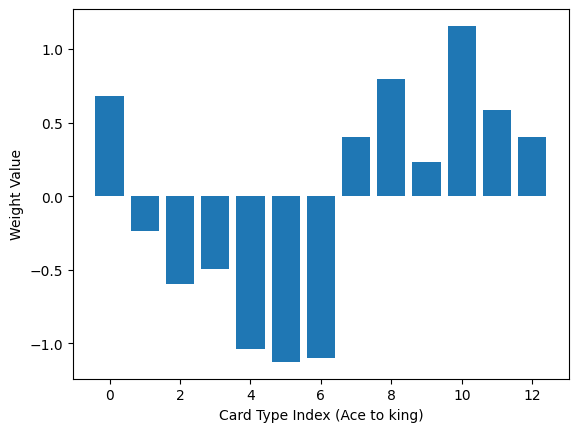

In [401]:
# plot a bar chart of the weights for the type of cards, not bias or other features 
weights = r_agent_adam.weights
card_weights = weights[1:-1]  # assuming first two weights are bias and other features
plt.bar(range(len(card_weights)), card_weights)
plt.xlabel('Card Type Index (Ace to king)')
plt.ylabel('Weight Value')

As you can see, the lower cards have a negative weight, meaning the more lower cards it sees, the less likely it will be to hit. The higher cards have positive weights so it does the opposite for them, the more positive cards it has seen, the more likely it will be to hit. 

This makes sense since if more higher cards have been seen, there are less of them in the deck, and therefore the agent will be less likely to bust if it hits. 

# Future Improvements/Limitations 

## Q-learning

## REINFORCE 

- use a better model, go from a linear model with an activation function to a full nueral network 

- Limited on compute power, REINFORCE is more computationally expensive, so harder to train on more episodes. 